# **Static Term structure Models - how to**

We will divide this into 2 chategories:
1. Compunational stuff, fit yield curve, discussion about it, find ZCB prices, spot rates etc.
2. Risk measures, etc

# **1 Computational stuff**

### **1.1 Discuss which characteristics the fitted term structures of spot and forward rates should have**

1) Minimum requirements

**Exact fit to market data:**  
The fitted term structure must exactly reprice all calibration instruments (deposits, FRAs, swaps). This ensures that the curve is free of static arbitrage relative to observed market prices.

**Positive discount factors:**  
Discount factors must be strictly positive for all maturities,
$$
P(0,T) > 0,
$$
since negative discount factors have no economic interpretation.

**Monotone discount factors:**  
Discount factors must be non-increasing in maturity,
$$
P(0,T_2) \le P(0,T_1), \quad T_2 > T_1,
$$
as violations would imply arbitrage opportunities and negative forward rates.

---

2) Smoothness requirements

**Continuous spot rates:**  
Spot rates should vary continuously with maturity, as this prevents artificial jumps in discounting and valuation when moving across maturities.

**Smooth forward rates:**  
Forward rates should be continuous and preferably continuously differentiable. Forward rates enter directly into swap pricing, risk measures, and interest-rate models, and kinks or jumps lead to unstable hedging, noisy DV01, and unreliable convexity estimates.

**Stable derivatives:**  
Since forward rates are derivatives of the spot curve, smoothness of the spot curve is essential for obtaining economically meaningful and numerically stable forwards.

---

3) Local dependence and stability

**Local dependence:**  
The shape of the curve between two maturities should depend primarily on nearby market instruments. A small change in a single quote should not distort the entire term structure.

**Stability under small data changes:**  
Small changes in market quotes should result in small changes in spot and forward rates. This prevents overreaction to market noise and ensures robustness in risk management and scenario analysis.

**Absence of artificial oscillations:**  
The fitted curve should not introduce spurious humps or wiggles between maturities. Such oscillations mainly contaminate forward rates and lead to unstable sensitivities.

---

4) Dependence on the type of market data

In practice, the available market data is sparse. Typically, one observes a few short-term deposits, a handful of FRAs, and a limited set of swap maturities. As a result, interpolation assumptions play a dominant role between quoted maturities. This makes smoothness, stability, and robustness more important than excessive flexibility. Consequently, interpolation methods must perform well even when data is scarce and unevenly distributed across maturities.

---

5) Why cubic Hermite splines are used

Cubic (degree-3) Hermite splines with smooth transitions satisfy all the requirements above and are therefore used almost universally in practice.

**Appropriate degree:**  
Cubic polynomials are the lowest-degree polynomials that ensure continuous first derivatives. This guarantees smooth spot curves and well-behaved forward rates without introducing unnecessary flexibility.

**Smooth and stable forward rates:**  
Hermite splines allow direct control over slopes, which leads to smooth and stable forward-rate curves. This is crucial for swap pricing, DV01 calculations, and convexity measures.

**Local control:**  
Each spline segment depends only on neighboring data points, ensuring that local changes in market quotes lead to local changes in the curve.

**Avoidance of higher-degree polynomials:**  
Higher-degree polynomial fits tend to introduce global oscillations, overfit market noise, and behave poorly at the boundaries of the curve. These effects result in unrealistic forward rates and unstable risk measures.

---

**Summary:**  
A fitted term structure should exactly reprice market instruments, produce positive and monotone discount factors, generate smooth and stable spot and forward rates, and remain robust under sparse market data. Cubic Hermite splines achieve these objectives while avoiding the instability and oscillatory behavior associated with higher-degree polynomial methods.

---


### **1.2 Fit Yield Curve, and Plot the term structures of fitted spot and forward rates for maturities up to 30 years**

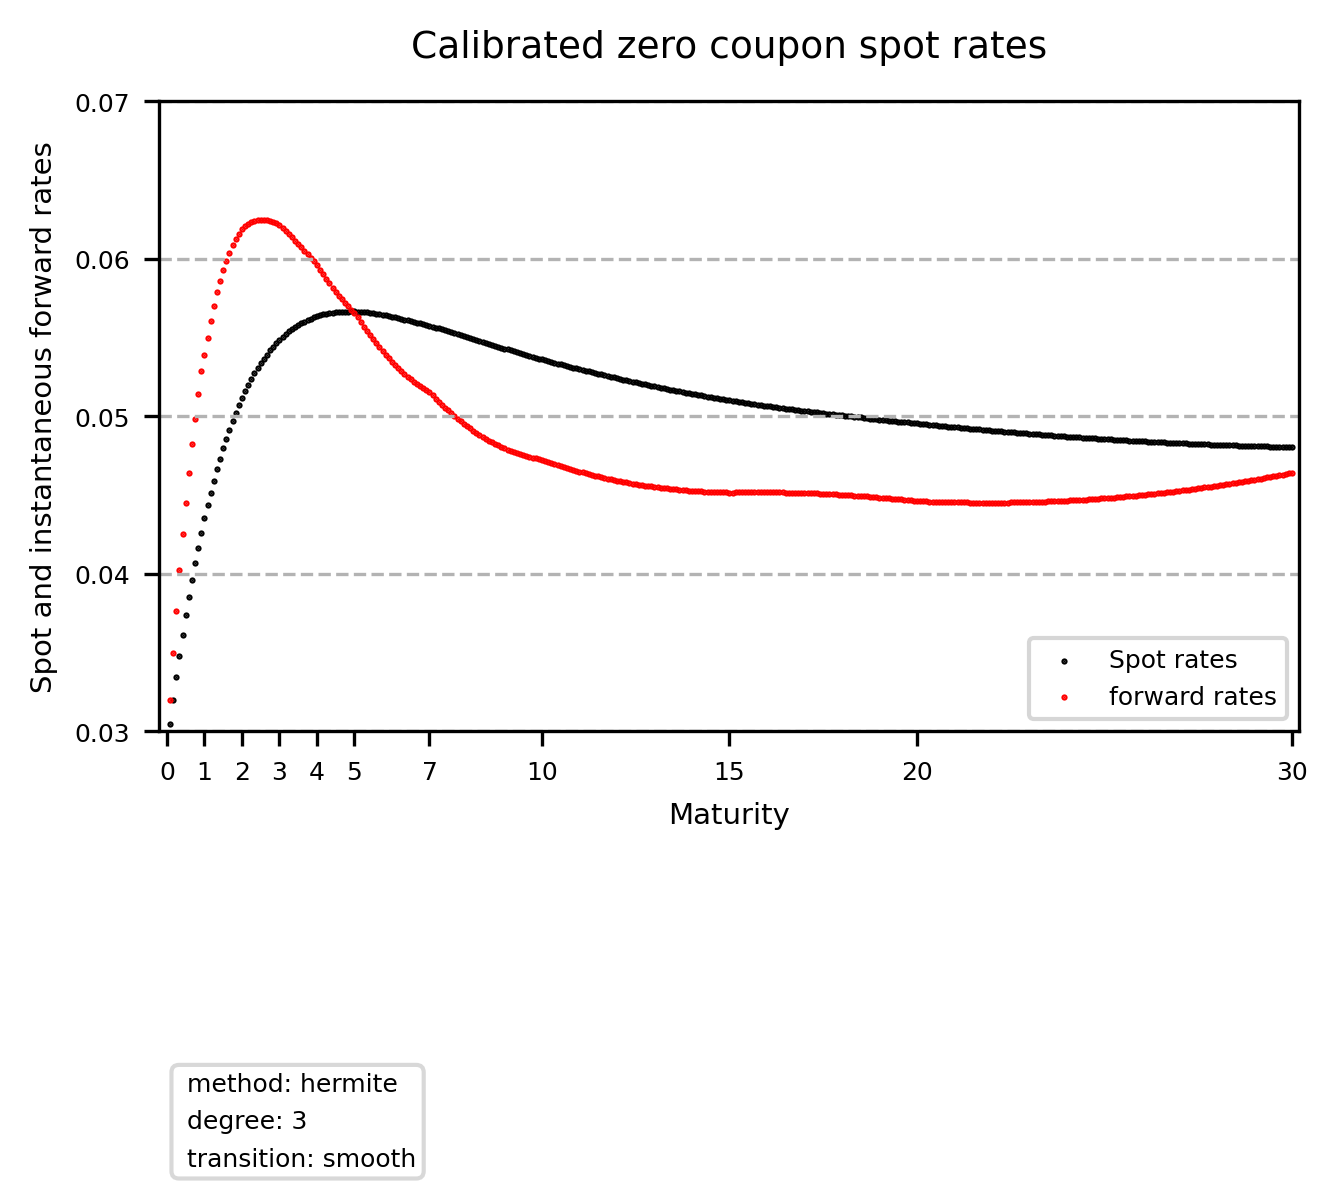

In [ ]:
# 1) Define market data on the usual format
# Loading packages
import numpy as np
import fixed_income_derivatives_E2025 as fid
import matplotlib.pyplot as plt

#Defining instruments and collecting in data
#Table 1: Euribor, FRA and Swap Market Data
EURIBOR_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate": 0.03772}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.04026},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.04261},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.04477},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.04677},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.04860},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.05029},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.05183},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.05324},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.05452}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.05228, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.05602, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.05755, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.05791, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.05718, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.05539, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05324, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05205, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05087, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data_zcb = EURIBOR_fixing + fra_market + swap_market

#2) Fit the yield curve
mesh = 1/12

M = 360

interpolation_options = {"method":"hermite","degree":3,"transition": "smooth"}

T_fit, R_fit = fid.zcb_curve_fit(data_zcb,interpolation_options = interpolation_options)

T_inter = np.array([i*mesh for i in range(0,M+1)])

p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter,T_fit,R_fit,interpolation_options = interpolation_options)

R_output = fid.for_values_in_list_find_value_return_value([0.5,1,2,5,10,15,20,30],T_inter,R_inter)

# 3) Plot the term structures of fitted spot and forward rates for maturities up to 30 years
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 7)
ax.set_yticks([0.03, 0.04, 0.05, 0.06, 0.07])
ax.set_yticklabels([0.03, 0.04, 0.05, 0.06, 0.07],fontsize = 6)
ax.set_ylim([0.03,0.07])
ax.set_ylabel(f"Spot and instantaneous forward rates",fontsize = 7)
plt.grid(axis = 'y', which='major', color = (0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter[1:], R_inter[1:], s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T_inter[1:], f_inter[1:], s = 1, color = 'red', marker = ".",label="forward rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
bbox = {"facecolor": (1,1,1,0.8),"edgecolor": (0.7,0.7,0.7,0.5),"boxstyle": "Round"}
if interpolation_options["method"] == "hermite":
    ax.text(0.32,0.0024,f" method: {interpolation_options['method']} \n degree: {interpolation_options['degree']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
else:
    ax.text(0.32,0.0024,f" method: {interpolation_options['method']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
plt.show()



#### **1.2.1. - Determine if the fit matches the data and, if so, provide evidence, such as reporting the Sum-of-Squared-Errors (SSE) of the fit.**

We can check if the data matches the fits by:
1. Calculating the FRAs
2. Calculating the Par Swp Rate

and check that they match with input data, this accounts for the shorter maturities

In [8]:
# for FRAs:
sse_fra = 0
print("\n" + "="*70)
print("FRA Rate Fit Verification (SSE Calculation)")
print("="*70)
print(f"{'FRA':<12} {'Market Rate':<18} {'Fitted Rate':<18} {'Squared Error':<18}")
print("-"*70)

for fra in fra_market:
    # Get ZCB prices at exercise and maturity times
    p_exer = fid.for_values_in_list_find_value_return_value(fra["exercise"], T_inter, p_inter)
    p_mat = fid.for_values_in_list_find_value_return_value(fra["maturity"], T_inter, p_inter)
    
    # Compute FRA rate from fitted curve (simple compounding)
    # FRA_rate = (p(T_exercise) - p(T_maturity)) / ((T_maturity - T_exercise) * p(T_maturity))
    tau = fra["maturity"] - fra["exercise"]
    R_fra_fitted = (p_exer - p_mat) / (tau * p_mat)
    
    R_fra_market = fra["rate"]
    squared_error = (R_fra_fitted - R_fra_market)**2
    sse_fra += squared_error
    print(f"{fra['exercise']*12:.0f}X{fra['maturity']*12:.0f}{'':<6} {R_fra_market:.6f} ({R_fra_market*100:.4f}%){'':<6} {R_fra_fitted:.6f} ({R_fra_fitted*100:.4f}%){'':<6} {squared_error:.2e}")

print("-"*70)
print(f"SSE from FRA portion: {sse_fra:.2e}")
print("="*70)



FRA Rate Fit Verification (SSE Calculation)
FRA          Market Rate        Fitted Rate        Squared Error     
----------------------------------------------------------------------
1X7       0.040260 (4.0260%)       0.040260 (4.0260%)       1.74e-32
2X8       0.042610 (4.2610%)       0.042610 (4.2610%)       3.25e-32
3X9       0.044770 (4.4770%)       0.044770 (4.4770%)       2.33e-32
4X10       0.046770 (4.6770%)       0.046770 (4.6770%)       6.93e-33
5X11       0.048600 (4.8600%)       0.048600 (4.8600%)       6.93e-33
6X12       0.050290 (5.0290%)       0.050290 (5.0290%)       2.12e-32
7X13       0.051830 (5.1830%)       0.051830 (5.1830%)       2.77e-32
8X14       0.053240 (5.3240%)       0.053240 (5.3240%)       1.08e-32
9X15       0.054520 (5.4520%)       0.054520 (5.4520%)       3.51e-32
----------------------------------------------------------------------
SSE from FRA portion: 1.82e-31


In [3]:
# For swap:
# 1. SSE from swap portion
sse_swap = 0
print("\n" + "="*70)
print("Swap Rate Fit Verification (SSE Calculation)")
print("="*70)
print(f"{'Maturity':<12} {'Market Rate':<18} {'Fitted Rate':<18} {'Squared Error':<18}")
print("-"*70)

for swap in swap_market:
    # Compute par swap rate from fitted curve
    R_swap_fitted, S_swap = fid.swap_rate_from_zcb_prices(0, 0, swap["maturity"], swap["fixed_freq"], T_inter, p_inter)
    R_swap_market = swap["rate"]
    squared_error = (R_swap_fitted - R_swap_market)**2
    sse_swap += squared_error
    print(f"{swap['maturity']}Y{'':<8} {R_swap_market:.6f} ({R_swap_market*100:.4f}%){'':<6} {R_swap_fitted:.6f} ({R_swap_fitted*100:.4f}%){'':<6} {squared_error:.2e}")

print("-"*70)
print(f"SSE from swap portion: {sse_swap:.2e}")
print("="*70)


Swap Rate Fit Verification (SSE Calculation)
Maturity     Market Rate        Fitted Rate        Squared Error     
----------------------------------------------------------------------
2Y         0.052280 (5.2280%)       0.052280 (5.2280%)       1.82e-25
3Y         0.056020 (5.6020%)       0.056020 (5.6020%)       5.89e-27
4Y         0.057550 (5.7550%)       0.057550 (5.7550%)       1.67e-26
5Y         0.057910 (5.7910%)       0.057910 (5.7910%)       5.65e-25
7Y         0.057180 (5.7180%)       0.057180 (5.7180%)       3.02e-26
10Y         0.055390 (5.5390%)       0.055390 (5.5390%)       3.73e-26
15Y         0.053240 (5.3240%)       0.053240 (5.3240%)       2.91e-26
20Y         0.052050 (5.2050%)       0.052050 (5.2050%)       8.33e-26
30Y         0.050870 (5.0870%)       0.050870 (5.0870%)       2.62e-26
----------------------------------------------------------------------
SSE from swap portion: 9.76e-25


### **1.3 Compute and report the par swap rates for the following maturities: 2Y, 5Y, 8Y, 10Y, and 30Y**

This code computes the par swap rates from the fitted zero-coupon bond curve. The par swap rate is the fixed rate
that makes the present value of the fixed leg equal to the present value of the floating leg, making the swap
have zero value at initiation. We use the swap_rate_from_zcb_prices function which computes the par swap rate
based on the ZCB prices from our fitted term structure. We also compare the computed rates to the market quotes
that were used in the calibration to verify the fit quality.

In [ ]:


# Compute par swap rates using swap_rate_from_zcb_prices function
R_2Y_swap, S_2Y_swap = fid.swap_rate_from_zcb_prices(0, 0, 2, "annual", T_inter, p_inter)
R_5Y_swap, S_5Y_swap = fid.swap_rate_from_zcb_prices(0, 0, 5, "annual", T_inter, p_inter)
R_8Y_swap, S_8Y_swap = fid.swap_rate_from_zcb_prices(0, 0, 8, "annual", T_inter, p_inter)
R_10Y_swap, S_10Y_swap = fid.swap_rate_from_zcb_prices(0, 0, 10, "annual", T_inter, p_inter)
R_30Y_swap, S_30Y_swap = fid.swap_rate_from_zcb_prices(0, 0, 30, "annual", T_inter, p_inter)

# Print results
print(f"1c - R_2Y_swap: {R_2Y_swap}, R_5Y_swap: {R_5Y_swap}, R_8Y_swap: {R_8Y_swap}, R_10Y_swap: {R_10Y_swap}, R_30Y_swap: {R_30Y_swap}")

# Also print in a more readable format with market comparison
print("\n" + "="*70)
print("Par Swap Rates Computation")
print("="*70)
print(f"{'Maturity':<12} {'Par Swap Rate':<18} {'Market Quote':<18} {'Difference (bp)':<18} {'Annuity':<15}")
print("-"*70)

# Market quotes from the calibration data (swap_market)
market_quotes = {
    2: 0.05228,   # 2Y swap rate from calibration
    5: 0.05791,   # 5Y swap rate from calibration
    8: None,      # 8Y swap not in market data
    10: 0.05539,  # 10Y swap rate from calibration
    30: 0.05087   # 30Y swap rate from calibration
}

swap_rates = {2: R_2Y_swap, 5: R_5Y_swap, 8: R_8Y_swap, 10: R_10Y_swap, 30: R_30Y_swap}
swap_annuities = {2: S_2Y_swap, 5: S_5Y_swap, 8: S_8Y_swap, 10: S_10Y_swap, 30: S_30Y_swap}

for T_swap in [2, 5, 8, 10, 30]:
    R_swap = swap_rates[T_swap]
    S_swap = swap_annuities[T_swap]
    market_rate = market_quotes.get(T_swap)
    if market_rate is not None:
        diff_bp = (R_swap - market_rate) * 10000
        print(f"{T_swap}Y{'':<8} {R_swap:.6f} ({R_swap*100:.4f}%){'':<6} {market_rate:.6f} ({market_rate*100:.4f}%){'':<6} {diff_bp:+.2f} bp{'':<6} {S_swap:.4f}")
    else:
        print(f"{T_swap}Y{'':<8} {R_swap:.6f} ({R_swap*100:.4f}%){'':<6} {'N/A (not in market)':<18} {'N/A':<18} {'':<6} {S_swap:.4f}")

print("="*70)

1c - R_2Y_swap: 0.052280000000426465, R_5Y_swap: 0.05790999999924803, R_8Y_swap: 0.05660107959929819, R_10Y_swap: 0.05538999999980689, R_30Y_swap: 0.050870000000161925

Par Swap Rates Computation
Maturity     Par Swap Rate      Market Quote       Difference (bp)    Annuity        
----------------------------------------------------------------------
2Y         0.052280 (5.2280%)       0.043290 (4.3290%)       +89.90 bp       1.8602
5Y         0.057910 (5.7910%)       0.056220 (5.6220%)       +16.90 bp       4.2599
8Y         0.056601 (5.6601%)       N/A (not in market) N/A                       6.2938
10Y         0.055390 (5.5390%)       0.059660 (5.9660%)       -42.70 bp       7.4922
30Y         0.050870 (5.0870%)       0.053340 (5.3340%)       -24.70 bp       15.0064


### **1.4 Compute 6-month (6M) forward Euribor rates, denoted as $L(0, T_{i-1}, T_i)$, for maturities up to $T_i = 30$ years.**

In [14]:
# 1. Compute 6M forward Euribor rates L(0, T_{i-1}, T_i) for maturities up to T_i = 30 years
# Create time array at 6M intervals: 0, 0.5, 1.0, ..., 30.0
T_6M = np.array([i*0.5 for i in range(0, 61)])  # 0 to 30 years in 0.5 year steps

# Get ZCB prices at 6M intervals from the fitted curve
p_6M = np.array(fid.for_values_in_list_find_value_return_value(T_6M, T_inter, p_inter))

# Compute 6M forward Euribor rates using simple compounding
# horizon=1 means look back 1 index, which is 0.5 years (6 months) since T_6M is spaced 0.5 years apart
L_6M = fid.forward_rates_from_zcb_prices(T_6M, p_6M, horizon=1, type="simple")

# L_6M[i] represents the forward rate from T_6M[i-1] to T_6M[i]

# Print the results
print("\n" + "="*70)
print("6-Month Forward Euribor Rates")
print("="*70)
print(f"{'Maturity':<12} {'Forward Rate':<18}")
print("-"*70)

for i in range(len(T_6M)):
    print(f"{T_6M[i]:.1f}Y{'':<8} {L_6M[i]:.6f} ({L_6M[i]*100:.4f}%)")

print("="*70)






6-Month Forward Euribor Rates
Maturity     Forward Rate      
----------------------------------------------------------------------
0.0Y         nan (nan%)
0.5Y         0.037720 (3.7720%)
1.0Y         0.050290 (5.0290%)
1.5Y         0.057664 (5.7664%)
2.0Y         0.061664 (6.1664%)
2.5Y         0.063168 (6.3168%)
3.0Y         0.063277 (6.3277%)
3.5Y         0.062434 (6.2434%)
4.0Y         0.061141 (6.1141%)
4.5Y         0.059502 (5.9502%)
5.0Y         0.057945 (5.7945%)
5.5Y         0.056349 (5.6349%)
6.0Y         0.054580 (5.4580%)
6.5Y         0.053295 (5.3295%)
7.0Y         0.052473 (5.2473%)
7.5Y         0.051494 (5.1494%)
8.0Y         0.050252 (5.0252%)
8.5Y         0.049262 (4.9262%)
9.0Y         0.048538 (4.8538%)
9.5Y         0.048076 (4.8076%)
10.0Y         0.047852 (4.7852%)
10.5Y         0.047587 (4.7587%)
11.0Y         0.047177 (4.7177%)
11.5Y         0.046820 (4.6820%)
12.0Y         0.046516 (4.6516%)
12.5Y         0.046264 (4.6264%)
13.0Y         0.046062 (4.6062%)
13.

### **1.5 Compute interest rate measures**


#### **1.5.1. Compute ZCB prices from spot rates**

In [15]:
# To compute ZCB prices from spot rates, we use the formula:
# P(0, T) = exp(-R(0, T) * T)
# where R(0, T) is the spot rate for maturity T. In practice we use the fitted spot rates from the previous exercise.

# Create a time array for the maturities we want to compute ZCB prices for
T_zcb = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0])

# Compute ZCB prices from spot rates
# Use the fitted spot rates at the desired maturities to compute ZCB prices using the provided function

# Get spot rates at T_zcb from the fitted curve.
spot_rates_zcb = np.array(fid.for_values_in_list_find_value_return_value(T_zcb, T_inter, R_inter))

# Compute ZCB prices from spot rates using continuous compounding
zcb_prices = fid.zcb_prices_from_spot_rates(T_zcb, spot_rates_zcb, type="continuous")

# Print ZCB prices for verification
print("\nZCB prices computed from spot rates:")
print(f"{'Maturity':<10} {'Spot Rate':<12} {'ZCB Price':<12}")
print("-"*36)
for i in range(len(T_zcb)):
    print(f"{T_zcb[i]:<10.2f} {spot_rates_zcb[i]:<12.6f} {zcb_prices[i]:<12.6f}")



ZCB prices computed from spot rates:
Maturity   Spot Rate    ZCB Price   
------------------------------------
0.50       0.037369     0.981489    
1.00       0.043518     0.957415    
1.50       0.047962     0.930584    
2.00       0.051155     0.902751    
2.50       0.053362     0.875111    
3.00       0.054851     0.848273    
3.50       0.055798     0.822594    
4.00       0.056351     0.798193    
4.50       0.056605     0.775132    
5.00       0.056657     0.753307    
5.50       0.056558     0.732664    
6.00       0.056332     0.713201    
6.50       0.056045     0.694689    
7.00       0.055741     0.676929    
7.50       0.055415     0.659938    
8.00       0.055053     0.643762    
8.50       0.054677     0.628287    
9.00       0.054304     0.613401    
9.50       0.053946     0.599002    
10.00      0.053613     0.585005    


#### **1.5.2. Compute spot rates from ZCB prices**

In [18]:
# Compute spot rates from ZCB prices using continuous compounding
spot_rates_zcb = fid.spot_rates_from_zcb_prices(T_zcb, zcb_prices, type="continuous")

# Print spot rates for verification
print("\nSpot rates computed from ZCB prices:")
print(f"{'Maturity':<10} {'ZCB Price':<12} {'Spot Rate':<12}")
print("-"*36)

for i in range(len(T_zcb)):
    print(f"{T_zcb[i]:<10.2f} {zcb_prices[i]:<12.6f} {spot_rates_zcb[i]:<12.6f}")




Spot rates computed from ZCB prices:
Maturity   ZCB Price    Spot Rate   
------------------------------------
0.50       0.981489     0.037369    
1.00       0.957415     0.043518    
1.50       0.930584     0.047962    
2.00       0.902751     0.051155    
2.50       0.875111     0.053362    
3.00       0.848273     0.054851    
3.50       0.822594     0.055798    
4.00       0.798193     0.056351    
4.50       0.775132     0.056605    
5.00       0.753307     0.056657    
5.50       0.732664     0.056558    
6.00       0.713201     0.056332    
6.50       0.694689     0.056045    
7.00       0.676929     0.055741    
7.50       0.659938     0.055415    
8.00       0.643762     0.055053    
8.50       0.628287     0.054677    
9.00       0.613401     0.054304    
9.50       0.599002     0.053946    
10.00      0.585005     0.053613    


#### **1.5.3. Compute forward rates from ZCB prices**

In [20]:
# Compute forward rates from ZCB prices using simple compounding
forward_rates = fid.forward_rates_from_zcb_prices(T_zcb, zcb_prices, type="simple")

# Print forward rates for verification
print("\nForward rates computed from ZCB prices:")
print(f"{'Maturity':<10} {'ZCB Price':<12} {'Forward Rate':<12}")
print("-"*36)

for i in range(len(T_zcb)):
    print(f"{T_zcb[i]:<10.2f} {zcb_prices[i]:<12.6f} {forward_rates[i]:<12.6f}")




Forward rates computed from ZCB prices:
Maturity   ZCB Price    Forward Rate
------------------------------------
0.50       0.981489     nan         
1.00       0.957415     0.050290    
1.50       0.930584     0.057664    
2.00       0.902751     0.061664    
2.50       0.875111     0.063168    
3.00       0.848273     0.063277    
3.50       0.822594     0.062434    
4.00       0.798193     0.061141    
4.50       0.775132     0.059502    
5.00       0.753307     0.057945    
5.50       0.732664     0.056349    
6.00       0.713201     0.054580    
6.50       0.694689     0.053295    
7.00       0.676929     0.052473    
7.50       0.659938     0.051494    
8.00       0.643762     0.050252    
8.50       0.628287     0.049262    
9.00       0.613401     0.048538    
9.50       0.599002     0.048076    
10.00      0.585005     0.047852    


#### **1.5.4. Compute accrual factor from ZCB prices**

In [22]:
#### **1.5.4. Compute accrual factor from ZCB prices**
# Compute accrual factors between each pair of ZCB maturities using the accrual_factor_from_zcb_prices function

# We will interpret accrual factor for [T_i-1, T_i] as the year fraction between T_i-1 and T_i (i.e., T_i - T_{i-1}) 
# times the discount factor at T_i (i.e., zcb_prices[i]). 
# This is consistent with the definition used in the fid module's accrual_factor_from_zcb_prices for a fixed schedule.

# Here we choose a frequency equal to the gap between consecutive maturities (assuming regularly spaced).
# Set up function calls for all intervals:
accrual_factors = []
for i in range(1, len(T_zcb)):
    t = 0  # current time
    T_n = T_zcb[i-1]
    T_N = T_zcb[i]
    fixed_freq = T_N - T_n   # this is the accrual period
    # Pass the entire T_zcb and zcb_prices arrays as T, p
    accrual = fid.accrual_factor_from_zcb_prices(t, T_n, T_N, fixed_freq, T_zcb, zcb_prices)
    accrual_factors.append(accrual)

# Print accrual factors for verification
print("\nAccrual factors computed from ZCB prices:")
print(f"{'Start (T0)':<12}{'End (T1)':<12}{'Accrual':<10}")
print("-"*34)
for i in range(1, len(T_zcb)):
    print(f"{T_zcb[i-1]:<12.2f}{T_zcb[i]:<12.2f}{accrual_factors[i-1]:<10.4f}")



Accrual factors computed from ZCB prices:
Start (T0)  End (T1)    Accrual   
----------------------------------
0.50        1.00        0.4787    
1.00        1.50        0.4653    
1.50        2.00        0.4514    
2.00        2.50        0.4376    
2.50        3.00        0.4241    
3.00        3.50        0.4113    
3.50        4.00        0.3991    
4.00        4.50        0.3876    
4.50        5.00        0.3767    
5.00        5.50        0.3663    
5.50        6.00        0.3566    
6.00        6.50        0.3473    
6.50        7.00        0.3385    
7.00        7.50        0.3300    
7.50        8.00        0.3219    
8.00        8.50        0.3141    
8.50        9.00        0.3067    
9.00        9.50        0.2995    
9.50        10.00       0.2925    


#### **1.5.5. Compute swap rate from ZCB prices**

In [26]:
# To compute the swap rate from ZCB prices, we use the swap_rate_from_zcb_prices function.
# This function computes the par swap rate from the ZCB prices and the fixed frequency of the swap.

# Compute par swap rate and swap annuity from ZCB prices for a 2 year swap
R_swap, S_swap = fid.swap_rate_from_zcb_prices(0, 0, 2, "annual", T_zcb, zcb_prices)

# Print the results
print("\nPar swap rate and swap annuity computed from ZCB prices:")
print(f"{'Swap Rate':<12} {'Swap Annuity':<12}")
print("-"*24)
print(f"{R_swap:.6f} ({R_swap*100:.4f}%){'':<6} {S_swap:.6f} ({S_swap*100:.4f}%)")




Par swap rate and swap annuity computed from ZCB prices:
Swap Rate    Swap Annuity
------------------------
0.052280 (5.2280%)       1.860165 (186.0165%)


### **1.6. Interest rate risk measures:**

#### **1.6.1. Compute Yield-To-Maturity**

To find the Yield-to-Maturity (YTM) for a zero-coupon bond (ZCB):
1. Recall that the price of a ZCB is the present value of its face value, discounted at the YTM over the bond's maturity.
2. The pricing formula for a ZCB is: Price = Face_Value / (1 + YTM)^T, where T is the maturity.
3. Rearranging this to solve for YTM gives: YTM = (Face_Value / Price)^(1/T) - 1.
4. In practice, if the bond price and maturity are known, input them into this formula to directly compute YTM.
5. For bonds with more complex cash flows, YTM is found by solving for the discount rate that sets the present value of all cash flows equal to the market price—often done numerically.
6. In code, a helper function (such as fid.ytm) is typically used, which finds the root of the equation: Present Value = sum of discounted cash flows.


In [35]:
# Example computation of Yield-To-Maturity (YTM) for a zero-coupon bond, from the example above
# Using a zcb with face value 100 and price 95, and maturity 2 years
# Example computation of Yield-To-Maturity (YTM) for a zero-coupon bond

# Define example values: face value, price, and time to maturity
face_value = 100     # Redemption value of the ZCB
price = 95           # Current market price of the ZCB
T = 2                # Maturity in years

# For the general helper function, we also need the cash flow structure and its times.
# For a ZCB, the cash flow is just at maturity, e.g. [face_value] at time [T]:
T_zcb_maturity = [T]
C_zcb = [face_value]

ytm_numerical = fid.ytm(price, T_zcb_maturity, C_zcb)
print("Yield-to-Maturity for ZCB:")
print(f"YTM = {ytm_numerical:.6f} ({ytm_numerical*100:.4f}%)")



Yield-to-Maturity for ZCB:
YTM = 0.025978 (2.5978%)


#### **1.6.2. Price fixed rate bond from YTM**

1. Identify all future cash flows of the bond (typically coupon payments and the face value at maturity).
2. Discount each cash flow back to the present using the bond's YTM as the discount rate.
    That is, for each cash flow C_i received at time T_i, the present value is C_i / (1 + YTM)^{T_i}.
3. Sum the present values of all cash flows to get the bond's price:
       Price = Σ [ C_i / (1 + YTM)^{T_i} ]
4. In practice, for bonds with annual coupons, T_i are the years until each payment.
5. In code, the helper function `fid.price_fixed_rate_bond_from_ytm(ytm, T, C)` computes this sum, where:
       - ytm: is the yield-to-maturity,
       - T: list or array of payment times,
       - C: list or array of corresponding cash flows.


In [36]:
# Example computation of Price from YTM for a fixed rate bond

# Define example values: yield-to-maturity, coupon rate, face value, and time to maturity
ytm = 0.05  # Yield-to-maturity in decimal form (5% as an example)
coupon_rate = 0.06  # Annual coupon rate in decimal form (6% as an example)
face_value = 100  # Face value of the bond
T = 2  # Maturity in years

# Calculate cash flows: annual coupon payments plus face value at maturity
C = [coupon_rate * face_value] * (T-1) + [face_value + coupon_rate * face_value]
T_fixed = list(range(1, T+1))  # Times to each cash flow

# Compute price from YTM using fid.price_fixed_rate_bond_from_ytm
price_from_ytm = fid.price_fixed_rate_bond_from_ytm(ytm, T_fixed, C)

# Print the results
print(f"Price from YTM: {price_from_ytm:.6f}")



Price from YTM: 101.859410


#### **1.6.3. Compute Macauley duration**

1. Identify all future cash flows (coupons and principal payments), and their times T_i.
2. For each cash flow C_i at time T_i, compute its present value using the yield-to-maturity (YTM): PV_i = C_i / (1 + YTM)^{T_i}.
3. Multiply each present value by its corresponding time T_i: Weight_i = T_i * PV_i.
4. Sum all these products across all cash flows to get the weighted average time of cash flows, discounted at YTM.
5. Finally, divide this sum by the current market price of the bond to obtain the Macauley duration:
      Macauley Duration = [ Σ (T_i * PV_i) ] / [ Bond Price ]

      
In Python, this can be computed using the helper function fid.macauley_duration(pv, T, C, ytm).


In [ ]:
# Example computation of Macauley duration for a fixed rate bond

# Define example values: yield-to-maturity, coupon rate, face value, and time to maturity
ytm = 0.05  # Yield-to-maturity in decimal form (5% as an example)
coupon_rate = 0.06  # Annual coupon rate in decimal form (6% as an example)
face_value = 100  # Face value of the bond
T = 2  # Maturity in years

# Calculate cash flows: annual coupon payments plus face value at maturity
C = [coupon_rate * face_value] * (T-1) + [face_value + coupon_rate * face_value]
T_fixed = list(range(1, T+1))  # Times to each cash flow

# Compute Macauley duration using fid.macauley_duration
macauley_duration = fid.macauley_duration(price_from_ytm, T_fixed, C, ytm)

# Print the results
print(f"Macauley Duration: {macauley_duration:.6f}")

# Interpretation: The Macauley duration of 1.9439 years indicates that, on average, the bond's cash flows are received 1.85 years from the present. 
# This is a measure of the bond's sensitivity to changes in interest rates.


Macauley Duration: 1.943900


#### **1.6.4. Compute modified duration**

In [44]:
# The modified duration is a measure of the sensitivity of a bond's price to changes in interest rates.
# It is calculated as the Macauley duration divided by (1 + YTM).
# In Python, this can be computed using the helper function fid.modified_duration(pv, T, C, ytm),
# where pv is the present value (bond price), T is the time array, C is the cash flow array, and ytm is the yield-to-maturity.

# Example computation of modified duration for a fixed rate bond
# Define example values: yield-to-maturity, coupon rate, face value, and time to maturity
ytm = 0.05  # Yield-to-maturity in decimal form (5% as an example)
coupon_rate = 0.06  # Annual coupon rate in decimal form (6% as an example)
face_value = 100  # Face value of the bond
T = 2  # Maturity in years

# Calculate cash flows: annual coupon payments plus face value at maturity
C = [coupon_rate * face_value] * (T-1) + [face_value + coupon_rate * face_value]
T_fixed = list(range(1, T+1))  # Times to each cash flow

# Compute price from YTM (needed for duration calculations)
price_from_ytm = fid.price_fixed_rate_bond_from_ytm(ytm, T_fixed, C)

# Compute Macauley duration using fid.macauley_duration
macauley_duration = fid.macauley_duration(price_from_ytm, T_fixed, C, ytm)

# Compute modified duration using fid.modified_duration
# Note: modified_duration requires (pv, T, C, ytm) as arguments, not (macauley_duration, ytm)
modified_duration = fid.modified_duration(price_from_ytm, T_fixed, C, ytm)

# print the results
print(f"Modified Duration: {modified_duration:.6f}")

# Interpretation: The modified duration of 1.85 years indicates that, for a 1% change in interest rates, 
# the bond's price is expected to change by approximately 1.85% in the opposite direction.



Modified Duration: 1.851334


#### **1.6.5. Convexity**

In [46]:
# We can compute convexity using the helper function fid.convexity(pv, T, C, ytm),
# where pv is the present value (bond price), T is the time array, C is the cash flow array, and ytm is the yield-to-maturity.

# Example computation of convexity for a fixed rate bond

# Define example values: yield-to-maturity, coupon rate, face value, and time to maturity
ytm = 0.05  # Yield-to-maturity in decimal form (5% as an example)
coupon_rate = 0.06  # Annual coupon rate in decimal form (6% as an example)
face_value = 100  # Face value of the bond
T = 2  # Maturity in years

# Calculate cash flows: annual coupon payments plus face value at maturity
C = [coupon_rate * face_value] * (T-1) + [face_value + coupon_rate * face_value]
T_fixed = list(range(1, T+1))  # Times to each cash flow

# Compute price from YTM (needed for convexity calculations)
price_from_ytm = fid.price_fixed_rate_bond_from_ytm(ytm, T_fixed, C)

# Compute convexity using fid.convexity
convexity = fid.convexity(price_from_ytm, T_fixed, C, ytm)

# Print the results
print(f"Convexity: {convexity:.6f}")

# Interpretation: Convexity measures the curvature of the bond's price-yield relationship. 
# So a value of 3.831701 indicates that the bond's price is more sensitive to changes in yield than a linear relationship would suggest.

# If convexity is positive, the bond's price will increase if interest rates fall, and decrease if interest rates rise.
# If convexity is negative, the bond's price will decrease if interest rates fall, and increase if interest rates rise.
# If convexity is zero, the bond's price will change linearly with interest rates.



Convexity: 3.831701


### **1.7 swaps**

1. Find Par swap rate
2. Find the accrual factor

In [54]:
# Example computation of receiver swap

# If we consider a 6Y receiver swap on which the holder pays 6M Euribor semiannually and receives an annual fixed rate,
# Example computation of par swap rate and accrual factor for a receiver swap

# Inputs (example)
t = 0                   # current time (swap inception)
T_n = 0                 # swap effective date (at inception)
T_N = 6                 # swap maturity (in years)
fixed_freq = "annual"   # fixed leg pays annually
float_freq = "semiannual"  # floating leg pays semiannually (not used for par rate at inception)
# Let’s assume flat yield curve for simplicity
n_steps = int(T_N) + 1
T_nodes = np.linspace(0, T_N, n_steps)
# Suppose flat curve at 4.5% continuously compounded
spot_rate = 0.045
p = np.exp(-spot_rate * T_nodes)

# Find par swap rate and accrual factor
receiver_swap_rate, accrual_factor = fid.swap_rate_from_zcb_prices(
    t, T_n, T_N, fixed_freq, T_nodes, p)

print(f"Par swap rate (receiver swap, 6Y maturity, annual fixed): {receiver_swap_rate:.6f}")
print(f"Accrual factor for fixed leg (sum of discounted year fractions): {accrual_factor:.6f}")






Par swap rate (receiver swap, 6Y maturity, annual fixed): 0.046028
Accrual factor for fixed leg (sum of discounted year fractions): 5.140811


### **1.8. Fixed-rate bond, find and report**
   1. the price,
   2. the yield-to-maturity,
   3. the duration,
   4. the convexity.

In [58]:
# For a 6Y fixed rate bond paying an annual coupon of 0.06,
# Example computation of price, yield-to-maturity, duration, and convexity for a fixed rate bond, with:
# Coupon rate = 0.06
# Face value = 100
# Maturity = 6Y 

# Define cash flows and times
C = [0.06 * 100] * 5 + [100 + 0.06 * 100]
T_fixed = list(range(1, 6+1))

# Find the ytm, using the fid.ytm function
ytm = fid.ytm(price, T_fixed, C)

# Compute price from YTM
price = fid.price_fixed_rate_bond_from_ytm(ytm, T_fixed, C)

# Compute duration and convexity
duration = fid.macauley_duration(price, T_fixed, C, ytm)
convexity = fid.convexity(price, T_fixed, C, ytm)

# Print the results
print(f"Price: {price:.6f}")
print(f"Yield-to-maturity: {ytm:.6f} ({ytm*100:.4f}%)")
print(f"Duration: {duration:.6f}")
print(f"Convexity: {convexity:.6f}")




Price: 101.859414
Yield-to-maturity: 0.056263 (5.6263%)
Duration: 5.220580
Convexity: 29.569832


### **1.9. -  6Y zero-coupon bond: Find and report:**
   - the price,
   - the yield-to-maturity,
   - the duration,
   - the convexity.

In [61]:
# Example computation of price, yield-to-maturity, duration, and convexity for a zero-coupon bond, with:
# Maturity = 6Y
# Face value = 100

# Use calibration from T_inter, p_inter (assume available in namespace as per earlier calibration)
mat_zcb = 6
K_zcb = 100

# Find interpolated price from discount curve (interpolated ZCB price)
p_zcb = fid.for_values_in_list_find_value_return_value(mat_zcb, T_inter, p_inter)

# Price of the zero-coupon bond
price = p_zcb * K_zcb

# Yield-to-maturity (annual, simple compounding)
ytm = (1/p_zcb)**(1/mat_zcb) - 1

# Duration and convexity for a zero-coupon bond
duration = mat_zcb
convexity = mat_zcb**2

# Print the results
print(f"Price: {price:.6f}")
print(f"Yield-to-maturity: {ytm:.6f} ({ytm*100:.4f}%)")
print(f"Duration: {duration:.6f}")
print(f"Convexity: {convexity:.6f}")


Price: 71.320089
Yield-to-maturity: 0.057949 (5.7949%)
Duration: 6.000000
Convexity: 36.000000


# **2) Risk measures and bumps**

### **2.1) Gains and loses for shift in yield curve**

In this example we consider the following instruments:
- A 6Y receiver swap on which the holder pays 6M Euribor and receives an annual fixed rate,
- A 6Y fixed rate bond paying an annual coupon of 0.06,
- A 6Y zero coupon bond.

All three instruments have a principal of K = 100 Euros.


### **2.2) Sensitivity to individual points on the ZCB spot rate curve.**
- A 6Y receiver swap on which the holder pays 6M Euribor and receives an annual fixed rate,
- A 6Y fixed rate bond paying an annual coupon of 0.06,
- A 6Y zero coupon bond.

All three instruments have a principal of K = 100 Euros.